In [242]:
import re
import random
import pandas as pd
import hashlib

In [243]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()  # Truncate to first 12 characters


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2.5e4: age_factor = 0.5
else: age_factor = 1.05

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.random() for _ in cards_to_age.index]

cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('age')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [244]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,head_count
Azure AI Foundry,56.494948,11.298990,5
IW Migration,164.632521,5.879733,28
Email Auth and Security,181.885057,8.267503,22
General,245.803417,61.450854,4
Workera.ai,289.797707,57.959541,5
Jane Eyre,295.452824,29.545282,10
Git,295.569636,59.113927,5
Dataverse,314.568506,62.913701,5
Diffusers Documentation,315.699840,63.139968,5
Dataverse Plugins,338.042103,48.291729,7


16416.673549657164


<Axes: >

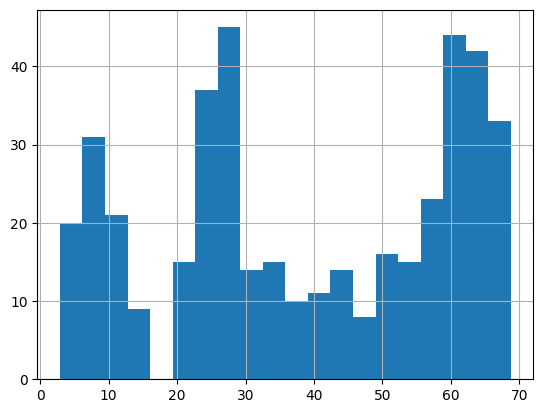

In [245]:
print(existing_cards['age'].sum())
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [246]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Shuffle

In [247]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

In [248]:
existing_cards[['head', 'age']].head(n = 10)

,head,age
0,General,55.972971
1,General,62.573925
2,General,63.384880
3,General,63.871641
4,Diffusers Documentation,58.034115
5,Diffusers Documentation,58.911636
6,Diffusers Documentation,64.504825
7,Diffusers Documentation,65.508410
8,Diffusers Documentation,68.740854
9,Git,53.958091


# Headers with fewest notes first

In [249]:
frequency = existing_cards['head'].value_counts(ascending=True)

existing_cards = pd.merge(
    left=existing_cards,
    right=frequency.rename('frequency'),
    left_on='head', right_index=True,
    how='left'
)
existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
existing_cards['age'] = existing_cards['age'] * -1


existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

Cards found: 423


In [250]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,oldest
3,General,Sectoral Diversity: Within the European Stoxx ...,3741107968cff74b73d068bca453a667,-63.871641,61.450854,-63.871641,245.803417,0.712063,4,63.871641
2,General,[Win] + [ctrl] + [v] opens the windows audio d...,c9cac70a8643ce4d1417ecc2a4d50461,-63.384880,61.450854,-63.871641,245.803417,0.712063,4,63.871641
1,General,Automatic VM guest patching: This refers to th...,a1fe67b1c263c4bb2a93f691cd50f2a6,-62.573925,61.450854,-63.871641,245.803417,0.712063,4,63.871641
0,General,Sideloading benefits include testing new app f...,3346a2199c02ca60b141eff6d8802d70,-55.972971,61.450854,-63.871641,245.803417,0.712063,4,63.871641
8,Diffusers Documentation,"On Windows, pip relies on a small launcher exe...",72502694afdcd59ba18edb412613112c,-68.740854,63.139968,-68.740854,315.699840,0.590894,5,68.740854
7,Diffusers Documentation,Schedulers manage going from a noisy sample to...,33f974a90a529fc459bebb059cab2c1f,-65.508410,63.139968,-68.740854,315.699840,0.590894,5,68.740854
6,Diffusers Documentation,The Stable Diffusion model is a good starting ...,eff6b91a6b52ad5e21804bab9cd3f529,-64.504825,63.139968,-68.740854,315.699840,0.590894,5,68.740854
5,Diffusers Documentation,The Scripts\ folder contains the pip executabl...,b4c635318e0167ffa9088203a64d7c4d,-58.911636,63.139968,-68.740854,315.699840,0.590894,5,68.740854
4,Diffusers Documentation,Choosing a more efficient scheduler could help...,329db08b8494c9d2dcea7e559d09c3cc,-58.034115,63.139968,-68.740854,315.699840,0.590894,5,68.740854
13,Git,git status: This command shows the current sta...,92da3e212ca7c72115d05183ead08f9a,-66.038687,59.113927,-66.038687,295.569636,0.604132,5,66.038687


In [251]:
existing_cards['head'].value_counts()

Azure Kubernetes Learning Path    41
Home Network Project              40
DNS                               31
IW Migration                      28
Search Engine Optimization        25
Email Auth and Security           22
Python                            21
PP365                             18
sklearn                           17
OData                             17
Azure Functions                   17
Diffusers Library                 16
Power BI                          11
MS Identity Platform              11
Jane Eyre                         10
Diffusers from Hugging Face       10
Kali Linux                        10
AKS                                8
pandas                             8
Dataverse Plugins                  7
Conditional Access                 7
Dataverse Queries                  7
Azure OpenAI                       6
Azure AI Search                    6
Diffusers Documentation            5
Azure AI Foundry                   5
Dataverse                          5
W

# Focus on one header

In [252]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [253]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [254]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# Headers with greatest age sum first

In [255]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle

## Random

In [256]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age').groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

## Age Sum

In [257]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)

## Age max

In [258]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)
# existing_cards.head(10)

# remake_card_document(existing_cards=existing_cards)